# Introduction 

This notebook documents one of the two main classes of models for image inpainting and generation, a variational autoencoder. 


# Initialization

## Imports

In [1]:
# functional
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import os
import lpips
from sklearn.model_selection import train_test_split
import time

# visualization
import matplotlib.pyplot as plt

# wandb
import wandb

# images
from skimage import io
from skimage import transform

# metrics
import torchmetrics


/home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import custom methods

In [2]:
import sys
sys.path.append("/home/e/e0425222/CS4243/")
from utils.dataset_utils.AnimalDataset import AnimalDataset
from utils.train_utils.train_utils import train_epoch, evaluate_epoch, train_evaluate, visualize_results, sample_batch

# Model

## Define model


 

In [3]:
class Conv2dBlock(nn.Module):

    def __init__(self, input_dim, output_dim, 
        kernel_size = 3, stride = 1, padding = 'same', dilation = 1, 
        activation = nn.ReLU):

        super(Conv2dBlock, self).__init__()

        # layers
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride, padding, dilation)
        self.activation = activation()
        self.bn = nn.BatchNorm2d(output_dim)

    def forward(self, input_tensor):
        
        x = input_tensor
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)

        return x

class ResidualConv2dBlock(nn.Module):

    def __init__(self, input_dim, 
        kernel_size = 3, stride = 1, dilation = 1, 
        activation = nn.ReLU):

        super(ResidualConv2dBlock, self).__init__()

        # layers
        self.conv1 = nn.Conv2d(input_dim, input_dim, kernel_size, stride,  padding = 'same', dilation = dilation)
        self.activation1 = activation()
        self.bn1 = nn.BatchNorm2d(input_dim)
        self.conv2 = nn.Conv2d(input_dim, input_dim, kernel_size, stride,  padding = 'same', dilation = dilation)
        self.bn2 = nn.BatchNorm2d(input_dim)
        self.activation2 = activation()

    def forward(self, input_tensor):
        
        x = input_tensor

        # first block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)

        # second block
        x = self.conv2(x)
        x = self.bn2(x)
        
        # residual
        x = x + input_tensor
        x = self.activation2(x)

        return x


class UpConv2dBlock(nn.Module):

    def __init__(self, input_dim, output_dim, 
        kernel_size = 3, stride = 1, padding = 'same', dilation = 1, 
        activation = nn.ReLU, 
        scale_factor = (2,2)):

        super(UpConv2dBlock, self).__init__()


        self.upsample = nn.Upsample(scale_factor = scale_factor, mode = 'nearest')
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride, padding, dilation)
        self.activation = activation()
        self.bn = nn.BatchNorm2d(output_dim)

    def forward(self, input_tensor):
        
        x = input_tensor
        x = self.upsample(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)

        return x


class VanillaVAE(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, input_shape, activation):
        super(VanillaVAE, self).__init__()

        
        # conv input to hidden dim -> downsample x2
        self.first = Conv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv1 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv2 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # 5x dilated residual conv, keep halving
        self.conv3 = ResidualConv2dBlock(hidden_dim, kernel_size = 3, stride = 1, dilation = 2, activation = activation)
        self.conv4 = ResidualConv2dBlock(hidden_dim, kernel_size = 3, stride = 1, dilation = 2, activation = activation)
        self.conv5 = ResidualConv2dBlock(hidden_dim, kernel_size = 3, stride = 1, dilation = 2, activation = activation)
        self.conv6 = ResidualConv2dBlock(hidden_dim, kernel_size = 3, stride = 1, dilation = 2, activation = activation)
        self.conv7 = ResidualConv2dBlock(hidden_dim, kernel_size = 3, stride = 1, dilation = 2, activation = activation)
 
        # pool down to get mu and sigma maps
        self.conv_mu = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 4, stride = 2, padding = 3, dilation = 2, activation = activation)
        self.conv_sigma = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 4, stride = 2, padding = 3, dilation = 2, activation = activation)

        # sample
        self.distribution = torch.distributions.Normal(0, 1)

        # metadata
        self.input_shape = input_shape

        # upsample conv x 4, doubling each time
        self.upconv0 = UpConv2dBlock(hidden_dim, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.upconv1 = UpConv2dBlock(hidden_dim, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.upconv2 = UpConv2dBlock(hidden_dim, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.upconv3 = UpConv2dBlock(hidden_dim, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # normal conv x 2
        self.upconv4 = ResidualConv2dBlock(hidden_dim, kernel_size = 3, stride = 1, dilation = 1, activation = activation)
        self.upconv5 = ResidualConv2dBlock(hidden_dim, kernel_size = 3, stride = 1, dilation = 1, activation = activation)

        # final
        self.final = nn.Conv2d(hidden_dim, output_dim, kernel_size = 3, stride = 1, padding = 'same')


    def forward(self, input_tensor):

        x = input_tensor

        # ===== ENCODE =====
        # encode down with conv
        x = self.first(input_tensor)

        # encode down
        x = self.conv1(x)
        x = self.conv2(x)

        # dilated convolutions
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)

        # distribution parameters 
        mu = self.conv_mu(x)
        rho = self.conv_sigma(x)

        # ===== SAMPLE =====
        # device
        device = mu.device

        # sample
        sample = self.distribution.sample(mu.shape).to(device)
        sd = torch.exp(rho) # always positive
        z = sample * sd + mu # reparamatrization trick

        # kl loss, for ~N(0, 1)
        kl = (0.5 * (sd**2 + mu**2 - 1) - torch.log(sd)).sum(dim = (1,2,3)).mean()

        # ===== UPSAMPLE =====
        x = self.upconv0(z)
        x = self.upconv1(x)
        x = self.upconv2(x)

        # conv with residual connections
        x = self.upconv3(x)
        x = self.upconv4(x)
        x = self.upconv5(x)

        # final projection
        x = self.final(x)

        return x, kl


    def summary(self, verbose = False):
        count = 0
        if verbose:
            print(self)

        for name, params in self.named_parameters():
            num_params = params.flatten().size()[0]
            count += num_params
            if verbose:
                print(f"\nlayer: {name}")
                print(f"number of params: {num_params}")
                print(f"params shape: {params.size()}")

        print(f"model has {count/1e6} million parameters")




## Initialize model


In [4]:
# model parameters
image_dim = 96
in_channels = 4
out_channels = 3
hidden_channels = 64
activation = nn.PReLU

# create model
model = VanillaVAE(in_channels, hidden_channels, out_channels, image_dim, activation)

model.summary(verbose = False)


model has 0.876826 million parameters


## Save model

In [5]:
MODEL_FOLDER = "/home/e/e0425222/CS4243/model_weights/VanillaVAE"

In [6]:
# save path
MODEL_NAME = "VanillaVAE_hidden64_prelu"
SAVE_PATH = f"{MODEL_FOLDER}/{MODEL_NAME}"

# save
torch.save(model.state_dict(), SAVE_PATH)

# sanity check
loaded = VanillaVAE(in_channels, hidden_channels, out_channels, image_dim, activation)


loaded.load_state_dict(torch.load(SAVE_PATH))
loaded.summary()
del loaded

model has 0.876826 million parameters


# Training Details
For training, we define all details here, and wrap it into two main dictionaries, `training_params` and `metrics`.

## Custom loss function

In [43]:
def mask_segmented_loss(output, target, mask, loss_function = nn.functional.l1_loss):
    """
    This is a custom functional loss function that considers where the mask is, and
    applies the loss function seperately. 
    """
    
    LOSS = loss_function # can use l1 loss or coarse to fine refinement


    def weighted_sum():
        MASKED_WEIGHT = 1
        UNMASKED_WEIGHT = 1

        # weights by mask, unmasked as 1
        masked_weights = (mask - 1) * -1 * MASKED_WEIGHT # invert the mask in a differentiable way
        unmasked_weights = mask * UNMASKED_WEIGHT
        
        # weighted sum
        loss_masked = LOSS(output, target, reduction = 'none')
        loss_unmasked = LOSS(output, target, reduction = 'none')
        loss = torch.mul(loss_masked, masked_weights) + torch.mul(loss_unmasked, unmasked_weights)
        loss = torch.mean(loss)
        return loss

    def only_masked():
        loss = LOSS(output, target, reduction = 'none')
        loss = torch.mul(loss, (-mask + 1))
        loss = torch.sum(loss)/torch.sum(-mask + 1)
        return loss

    def masked_with_unmaskedgt():
        img = (-mask + 1) * output + mask * target
        loss = LOSS(img, target, reduction = 'mean')
        return loss

    # only masked
    loss = only_masked()

    return loss


## Training parameters


In [8]:
# device
parallel = False
device = 'cuda:1'  
devices = [1, 2, 3]

if not parallel:
    model = model.to(device)
else:
    model = nn.DataParallel(model, device_ids = devices)

In [18]:
# define training parameters
num_epochs = 20
batch_size = 256

# optimizer parameters
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

# loss function 
loss_function = mask_segmented_loss

# wrap into dictionary
training_params = {
    "num_epochs" : num_epochs,
    "batch_size" : batch_size, 
    "learning_rate": learning_rate,
    "optimizer" : optimizer,
    "scheduler" : scheduler,
    "schedule_every" : 1,
    "loss_function" : loss_function,
    "save_path" : SAVE_PATH,
    "kl_weight" : 0.01
}



## Load Frogs dataset

In [19]:
concat_mask = True
dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243/dataset/frogs/frogs_wanted_indices_url.txt",
                        root_dir_path = "/home/e/e0425222/CS4243/dataset/frogs/images",
                        local_dir_path = f"/home/e/e0425222/CS4243/dataset/frogs/preprocessed_{image_dim}",
                        file_prefix = "frog_",
                        image_dimension = image_dim,
                        concat_mask = concat_mask,
                        require_init = False,
                        drops = [3839])

# train-test split
VALID_SIZE = 0.2
NUM_WORKERS = 2

indices = torch.arange(len(dataset))
train_indices, validation_indices = train_test_split(indices, test_size = VALID_SIZE)
train_dataset = Subset(dataset, train_indices)
validation_dataset = Subset(dataset, validation_indices)


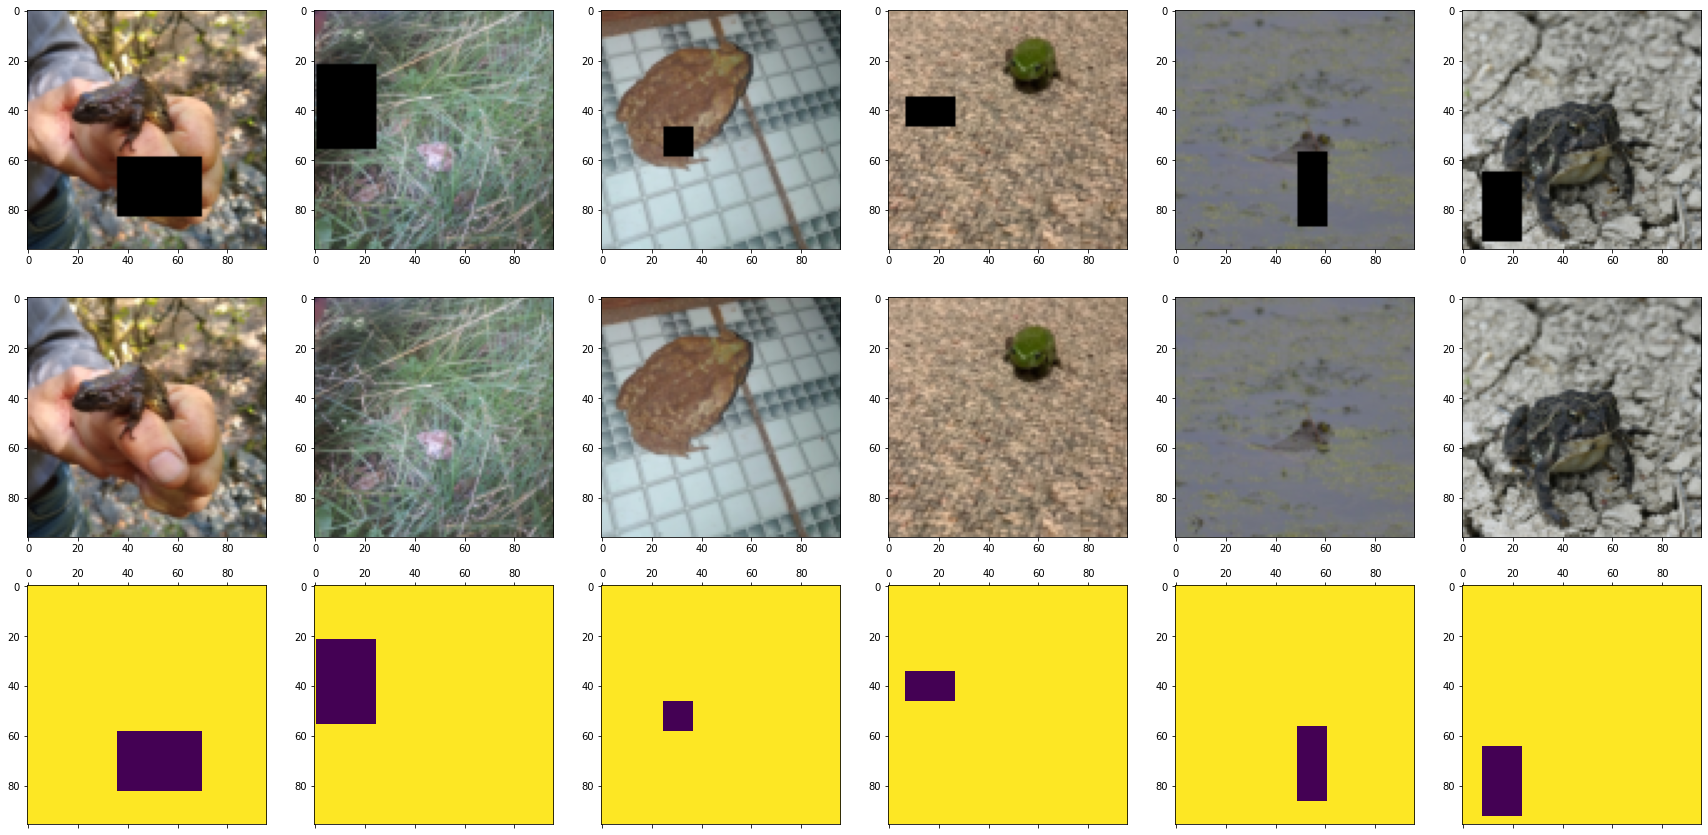

In [20]:
sample_batch(dataset, sample_size = 6)

In [21]:
# training config file
config = {
    "model_name" : MODEL_NAME,
    "dataset_details" : {
        "img_dim" : image_dim,
        "indices_file" : "frogs_wanted_indices_url.txt",
        "random_crop" : True,
        "concat_mask" : True
    },
    "train" : {
        "num_epochs" : num_epochs,
        "batch_size" : batch_size, 
        "learning_rate": learning_rate,
        "optimizer" : "ADAM",
        "scheduler" : {
            "name" : "ReduceLROnPlateau",
            "params" : ['min', 0.5, 3, 1e-6]
        },
        "schedule_every" : 1,
        "loss_function" : {
            "description" : "masked reconstruction loss, loss only applied to masked region",
            "loss_function" : "l1 loss + kl loss"
        },
    }
}

# wandb logging
wandb.init(project="VanillaVAE", entity="cs4243_project")
wandb.config = config


loss,█▇▆▇▆▇▇▆▃▆▂▆▂▃▂▁▁▂▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.11766
lr,0.0005


# Training

## Helper functions

## Pretraining reconstruction(without KL loss)

In [23]:
pretrain_loss_function = lambda img, gt, mask : nn.functional.l1_loss(img, gt)
training_params["loss_function"] = pretrain_loss_function
training_params["kl_weight"] = 0

# instantiate metric objects if needed
VGG_LPIPS = lpips.LPIPS(net = 'vgg').to(device)

# define metrics
pretrain_metrics = {
    "Peak SnR" : lambda img, gt, mask : torchmetrics.functional.peak_signal_noise_ratio(img, gt),
    "L2 loss" : lambda img, gt, mask : nn.functional.mse_loss(img, gt),
    "L1 loss" : lambda img, gt, mask : nn.functional.l1_loss(img, gt),
    "learned perceptual image patch similarity" : (lambda img, gt, mask : VGG_LPIPS(img, gt).mean())
}


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


In [27]:
torch.autograd.set_detect_anomaly(True)

# train
running_train_results, running_eval_results = train_evaluate(model, device, train_dataset, validation_dataset, training_params, pretrain_metrics, start_epoch = 20, pure_reconstruct = True)


===== Epoch: 21 ===== 
47/47: Peak SnR: 19.308750436661093   L2 loss: 0.011739094127365884   L1 loss: 0.07552757637297854   learned perceptual image patch similarity: 0.5942489428723112   loss: 0.07552757637297854   
12/12: Peak SnR: 16.164931297302246   L2 loss: 0.024194723616043728   L1 loss: 0.09860312007367611   learned perceptual image patch similarity: 0.6035622010628382   loss: 0.09860312007367611   
Completed epoch 21! Took 0.6549237728118896 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 22 ===== 
47/47: Peak SnR: 19.417351661844457   L2 loss: 0.011445570459708254   L1 loss: 0.07444385993987956   learned perceptual image patch similarity: 0.5897327572741407   loss: 0.07444385993987956   
12/12: Peak SnR: 15.867717504501343   L2 loss: 0.025917252836128075   L1 loss: 0.0983774463335673   learned perceptual image patch similarity: 0.6017309079567591   loss: 0.0983774463335673     
Completed epoch 22! Took 0.5816124002138774 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 23 ===== 
47/47: Peak SnR: 19.404842863691613   L2 loss: 0.011478370650017515   L1 loss: 0.07485515275534163   learned perceptual image patch similarity: 0.5870181816689511   loss: 0.07485515275534163   
12/12: Peak SnR: 16.141902923583984   L2 loss: 0.02432686323300004   L1 loss: 0.09674297273159027   learned perceptual image patch similarity: 0.5983040432135264   loss: 0.09674297273159027    
Completed epoch 23! Took 0.5680203278859456 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 24 ===== 
47/47: Peak SnR: 19.342200299526784   L2 loss: 0.011649623651929359   L1 loss: 0.07442196712214896   learned perceptual image patch similarity: 0.5858736266481116   loss: 0.07442196712214896   
12/12: Peak SnR: 16.288912852605183   L2 loss: 0.02360646768162648   L1 loss: 0.09552828284601371   learned perceptual image patch similarity: 0.5969255616267523   loss: 0.09552828284601371   
Completed epoch 24! Took 0.6428930083910624 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 25 ===== 
47/47: Peak SnR: 19.463325054087537   L2 loss: 0.01133174875235938   L1 loss: 0.0742024747615165   learned perceptual image patch similarity: 0.5830354284732899   loss: 0.0742024747615165      
12/12: Peak SnR: 16.032451629638672   L2 loss: 0.02494571901236971   L1 loss: 0.09694943949580193   learned perceptual image patch similarity: 0.5943756053845087   loss: 0.09694943949580193   
Completed epoch 25! Took 0.5909844358762105 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 26 ===== 
47/47: Peak SnR: 19.52640935207935   L2 loss: 0.011161875118442039   L1 loss: 0.07324513491797954   learned perceptual image patch similarity: 0.5799412587855725   loss: 0.07324513491797954    
12/12: Peak SnR: 16.18936276435852   L2 loss: 0.024057776511957247   L1 loss: 0.09637482526401679   learned perceptual image patch similarity: 0.593113899230957   loss: 0.09637482526401679    
Completed epoch 26! Took 0.6486889600753785 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 27 ===== 
47/47: Peak SnR: 19.56265185741668   L2 loss: 0.01106742226538506   L1 loss: 0.07287095185924083   learned perceptual image patch similarity: 0.5772180709433048   loss: 0.07287095185924083     
12/12: Peak SnR: 16.042335828145344   L2 loss: 0.02488503574083249   L1 loss: 0.09626938961446285   learned perceptual image patch similarity: 0.592039500673612   loss: 0.09626938961446285    
Completed epoch 27! Took 0.5868798136711121 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 28 ===== 
47/47: Peak SnR: 19.599408535247154   L2 loss: 0.010973188609994472   L1 loss: 0.07259194394375415   learned perceptual image patch similarity: 0.5750819774384194   loss: 0.07259194394375415   
12/12: Peak SnR: 16.247618675231934   L2 loss: 0.02374018294115861   L1 loss: 0.09427528642117977   learned perceptual image patch similarity: 0.5881236990292867   loss: 0.09427528642117977    
Completed epoch 28! Took 0.6319766481717427 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 29 ===== 
47/47: Peak SnR: 19.625868655265645   L2 loss: 0.01090837170944569   L1 loss: 0.07227798313536543   learned perceptual image patch similarity: 0.573100319568147   loss: 0.07227798313536543     
12/12: Peak SnR: 16.165558338165283   L2 loss: 0.02418605439985792   L1 loss: 0.0947351170082887   learned perceptual image patch similarity: 0.5853208849827448   loss: 0.0947351170082887     
Completed epoch 29! Took 0.5931623021761576 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 30 ===== 
47/47: Peak SnR: 19.649155758796855   L2 loss: 0.010851490450032215   L1 loss: 0.07204657095543882   learned perceptual image patch similarity: 0.5713762742407779   loss: 0.07204657095543882   
12/12: Peak SnR: 16.19330867131551   L2 loss: 0.024037644111861784   L1 loss: 0.0944916723916928   learned perceptual image patch similarity: 0.5867879341046015   loss: 0.0944916723916928     
Completed epoch 30! Took 0.5645744760831197 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 31 ===== 
47/47: Peak SnR: 19.681272628459524   L2 loss: 0.010773911319197492   L1 loss: 0.07161271857454422   learned perceptual image patch similarity: 0.5695985530285125   loss: 0.07161271857454422   
12/12: Peak SnR: 16.189953883488972   L2 loss: 0.02405668670932452   L1 loss: 0.09449457128842671   learned perceptual image patch similarity: 0.5840725898742676   loss: 0.09449457128842671   
Completed epoch 31! Took 0.60103253920873 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 32 ===== 
47/47: Peak SnR: 19.688322026678858   L2 loss: 0.01075361770121975   L1 loss: 0.07166876659748402   learned perceptual image patch similarity: 0.56829434633255   loss: 0.07166876659748402      
12/12: Peak SnR: 16.450070063273113   L2 loss: 0.022652187074224155   L1 loss: 0.0931839340676864   learned perceptual image patch similarity: 0.5831369509299597   loss: 0.0931839340676864    
Completed epoch 32! Took 0.6315084457397461 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 33 ===== 
47/47: Peak SnR: 19.715863491626497   L2 loss: 0.010683417320251465   L1 loss: 0.07127811949937901   learned perceptual image patch similarity: 0.5669408605453816   loss: 0.07127811949937901   
12/12: Peak SnR: 16.34713061650594   L2 loss: 0.02320440672338009   L1 loss: 0.09366495845218499   learned perceptual image patch similarity: 0.5820202181736628   loss: 0.09366495845218499     
Completed epoch 33! Took 0.7112760186195374 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 34 ===== 
47/47: Peak SnR: 19.73177447217576   L2 loss: 0.010647249507143143   L1 loss: 0.07110584178503523   learned perceptual image patch similarity: 0.5656714693028876   loss: 0.07110584178503523    
12/12: Peak SnR: 16.391361872355144   L2 loss: 0.022974118124693632   L1 loss: 0.0934259897718827   learned perceptual image patch similarity: 0.5803018907705942   loss: 0.0934259897718827     
Completed epoch 34! Took 0.561432957649231 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 35 ===== 
47/47: Peak SnR: 19.74142691429625   L2 loss: 0.010619945289131174   L1 loss: 0.07104078680276871   learned perceptual image patch similarity: 0.5646218277038412   loss: 0.07104078680276871    
12/12: Peak SnR: 16.355470339457195   L2 loss: 0.023166928440332413   L1 loss: 0.09307743236422539   learned perceptual image patch similarity: 0.5793421119451523   loss: 0.09307743236422539   
Completed epoch 35! Took 0.5629544019699096 min
saved plots!
saved model!

===== Epoch: 36 ===== 
47/47: Peak SnR: 19.747471789096263   L2 loss: 0.01060720578707913   L1 loss: 0.07091039593549485   learned perceptual image patch similarity: 0.563688076556997   loss: 0.07091039593549485     
12/12: Peak SnR: 16.286491870880127   L2 loss: 0.023532399131606024   L1 loss: 0.09312885875503223   learned perceptual image patch similarity: 0.5789735863606135   loss: 0.09312885875503223   
Completed epoch 36! Took 0.5669700781504313 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 37 ===== 
47/47: Peak SnR: 19.74895493527676   L2 loss: 0.010604763859288489   L1 loss: 0.07093757375123654   learned perceptual image patch similarity: 0.5631554139421341   loss: 0.07093757375123654    
12/12: Peak SnR: 16.288196245829266   L2 loss: 0.023519127784917753   L1 loss: 0.0932471714913845   learned perceptual image patch similarity: 0.5781027674674988   loss: 0.0932471714913845    
Completed epoch 37! Took 0.6308806777000427 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 38 ===== 
47/47: Peak SnR: 19.754118615008416   L2 loss: 0.010589768872299093   L1 loss: 0.07093852314543217   learned perceptual image patch similarity: 0.5625619812214628   loss: 0.07093852314543217   
12/12: Peak SnR: 16.219273408253986   L2 loss: 0.023893159503738087   L1 loss: 0.0935870526979367   learned perceptual image patch similarity: 0.5779904176791509   loss: 0.0935870526979367    
Completed epoch 38! Took 0.5722312410672505 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 39 ===== 
47/47: Peak SnR: 19.76230812072754   L2 loss: 0.010572079034086237   L1 loss: 0.07083574730031034   learned perceptual image patch similarity: 0.5624921791096951   loss: 0.07083574730031034    
12/12: Peak SnR: 16.267313083012898   L2 loss: 0.023639914424469072   L1 loss: 0.09340858645737171   learned perceptual image patch similarity: 0.5777822335561117   loss: 0.09340858645737171   
Completed epoch 39! Took 0.5678898652394613 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 40 ===== 
47/47: Peak SnR: 19.767105751849236   L2 loss: 0.010562467824746954   L1 loss: 0.0707371490115815   learned perceptual image patch similarity: 0.5616937710883769   loss: 0.0707371490115815     
12/12: Peak SnR: 16.236456155776978   L2 loss: 0.0238083569953839   L1 loss: 0.09357114136219025   learned perceptual image patch similarity: 0.577574223279953   loss: 0.09357114136219025     
Completed epoch 40! Took 0.7533251404762268 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!


## Training on reconstruction (with KL loss)

In [28]:
training_params["kl_weight"] = 0.01

# train
running_train_results, running_eval_results = train_evaluate(model, device, train_dataset, validation_dataset, training_params, pretrain_metrics, start_epoch = 40, pure_reconstruct = True)


===== Epoch: 41 ===== 
47/47: Peak SnR: 19.421297803838204   L2 loss: 0.01144598662219149   L1 loss: 0.07563448697328568   learned perceptual image patch similarity: 0.5692948318542318   loss: 62.22653880017869     
12/12: Peak SnR: 16.36154826482137   L2 loss: 0.023117784565935533   L1 loss: 0.09730281804998715   learned perceptual image patch similarity: 0.5891445577144623   loss: 44.39742936427394    
Completed epoch 41! Took 0.559852929910024 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 42 ===== 
47/47: Peak SnR: 19.257002039158596   L2 loss: 0.01187269258847896   L1 loss: 0.07793960862971366   learned perceptual image patch similarity: 0.5783895444362721   loss: 35.88757048261927     
12/12: Peak SnR: 16.422006289164226   L2 loss: 0.022807790742566187   L1 loss: 0.0973798433939616   learned perceptual image patch similarity: 0.5910758972167969   loss: 41.95406848271688    
Completed epoch 42! Took 0.5660193880399068 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 43 ===== 
47/47: Peak SnR: 19.241952530881193   L2 loss: 0.011916089287780702   L1 loss: 0.07790527809807594   learned perceptual image patch similarity: 0.5797134942196785   loss: 35.17424530678607    
12/12: Peak SnR: 16.464422702789307   L2 loss: 0.022583917248994112   L1 loss: 0.09701200698812802   learned perceptual image patch similarity: 0.5924844145774841   loss: 41.175024702300625   
Completed epoch 43! Took 0.5670882582664489 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 44 ===== 
47/47: Peak SnR: 19.202576129994494   L2 loss: 0.01202414577153135   L1 loss: 0.07827004726896895   learned perceptual image patch similarity: 0.5807800026650124   loss: 34.70497456002742     
12/12: Peak SnR: 16.358285983403523   L2 loss: 0.023153891166051228   L1 loss: 0.09795280049244563   learned perceptual image patch similarity: 0.5932616790135702   loss: 41.063072429398694   
Completed epoch 44! Took 0.622118862469991 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 45 ===== 
47/47: Peak SnR: 19.19524411952242   L2 loss: 0.012045904974195552   L1 loss: 0.07842865189973344   learned perceptual image patch similarity: 0.5812982599785987   loss: 34.46299418997258     
12/12: Peak SnR: 16.487735271453857   L2 loss: 0.022461832500994205   L1 loss: 0.09712244073549907   learned perceptual image patch similarity: 0.5934973110755285   loss: 39.88508203546206   
Completed epoch 45! Took 0.70640709400177 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 46 ===== 
47/47: Peak SnR: 19.187024826699115   L2 loss: 0.012068252376419432   L1 loss: 0.07846136835027248   learned perceptual image patch similarity: 0.5815379733734942   loss: 34.29753713404879    
12/12: Peak SnR: 16.314791838328045   L2 loss: 0.023372511845082045   L1 loss: 0.09855121436218421   learned perceptual image patch similarity: 0.5936507483323415   loss: 40.26429563981791   
Completed epoch 46! Took 0.5660897731781006 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 47 ===== 
47/47: Peak SnR: 19.16788141778175   L2 loss: 0.012119813861840583   L1 loss: 0.07870797464188109   learned perceptual image patch similarity: 0.5819413852184376   loss: 34.19107193642474     
12/12: Peak SnR: 16.42999203999837   L2 loss: 0.022760963533073664   L1 loss: 0.09763597200314204   learned perceptual image patch similarity: 0.5936572750409445   loss: 39.86115668326617    
Completed epoch 47! Took 0.5650649825731914 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 48 ===== 
47/47: Peak SnR: 19.1710082115011   L2 loss: 0.012109570383550004   L1 loss: 0.07873796941118037   learned perceptual image patch similarity: 0.5817977545109201   loss: 34.130973572426655     
12/12: Peak SnR: 16.35613552729289   L2 loss: 0.023145167001833517   L1 loss: 0.09823743999004364   learned perceptual image patch similarity: 0.5937404086192449   loss: 39.66135918478171    
Completed epoch 48! Took 0.6529120484987895 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 49 ===== 
47/47: Peak SnR: 19.182686501360955   L2 loss: 0.012077881320518381   L1 loss: 0.07852886585479087   learned perceptual image patch similarity: 0.5824961231109944   loss: 34.06089190219311    
12/12: Peak SnR: 16.469536304473877   L2 loss: 0.022561950298647087   L1 loss: 0.09744473112126191   learned perceptual image patch similarity: 0.5943048447370529   loss: 39.2009656458348    
Completed epoch 49! Took 0.5651081283887227 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 50 ===== 
47/47: Peak SnR: 19.162077518219643   L2 loss: 0.012136236150214013   L1 loss: 0.07878413273298994   learned perceptual image patch similarity: 0.5821947899270565   loss: 34.03835783613489    
12/12: Peak SnR: 16.442026774088543   L2 loss: 0.022691052872687578   L1 loss: 0.0975351973126332   learned perceptual image patch similarity: 0.593905915816625   loss: 39.349096273159   16   
Completed epoch 50! Took 0.5753617564837138 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 51 ===== 
47/47: Peak SnR: 19.170212887703105   L2 loss: 0.012114431154220662   L1 loss: 0.07870332088242186   learned perceptual image patch similarity: 0.5821947975361601   loss: 34.05023477432576    
12/12: Peak SnR: 16.426772753397625   L2 loss: 0.022784318774938583   L1 loss: 0.0976746225108703   learned perceptual image patch similarity: 0.5941527336835861   loss: 39.475935730909306   
Completed epoch 51! Took 0.6647502422332764 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 52 ===== 
47/47: Peak SnR: 19.170091344955118   L2 loss: 0.012113661148605194   L1 loss: 0.07865062419404374   learned perceptual image patch similarity: 0.5821516158732962   loss: 33.995549871566446   
12/12: Peak SnR: 16.45458984375   L2 loss: 0.022634417439500492   L1 loss: 0.09754072812696298   learned perceptual image patch similarity: 0.5941730588674545   loss: 39.55992374407749       
Completed epoch 52! Took 0.5686099370320638 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 53 ===== 
47/47: Peak SnR: 19.169973779231945   L2 loss: 0.012115997242483688   L1 loss: 0.07866514505858117   learned perceptual image patch similarity: 0.5825331857863892   loss: 33.962481316099776   
12/12: Peak SnR: 16.39946715037028   L2 loss: 0.02293888448427121   L1 loss: 0.09789151822527249   learned perceptual image patch similarity: 0.5938750704129537   loss: 39.50618619595965     
Completed epoch 53! Took 0.6491646925608318 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 54 ===== 
47/47: Peak SnR: 19.165384049111225   L2 loss: 0.012128774552269185   L1 loss: 0.07873863600035931   learned perceptual image patch similarity: 0.5821097112716512   loss: 33.973464154182594   
12/12: Peak SnR: 16.416348457336426   L2 loss: 0.02282828651368618   L1 loss: 0.09773297359546025   learned perceptual image patch similarity: 0.5941155850887299   loss: 39.01606264481942   
Completed epoch 54! Took 0.5705891092618306 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 55 ===== 
47/47: Peak SnR: 19.163041784408243   L2 loss: 0.012134089748910133   L1 loss: 0.07873258295845478   learned perceptual image patch similarity: 0.5824818902827323   loss: 33.9838681322463     
12/12: Peak SnR: 16.370028654734295   L2 loss: 0.023079722343633573   L1 loss: 0.09832590321699779   learned perceptual image patch similarity: 0.5943915843963623   loss: 39.47048776845137   
Completed epoch 55! Took 0.565902070204417 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 56 ===== 
47/47: Peak SnR: 19.154534847178358   L2 loss: 0.012157294106610279   L1 loss: 0.07884129120948467   learned perceptual image patch similarity: 0.5824113361378933   loss: 33.962262660899064   
12/12: Peak SnR: 16.493196805318195   L2 loss: 0.022430790898700554   L1 loss: 0.09717505984008312   learned perceptual image patch similarity: 0.5942827314138412   loss: 39.60069068484008   
Completed epoch 56! Took 0.5652740796407064 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 57 ===== 
47/47: Peak SnR: 19.170453862941013   L2 loss: 0.012112774688037151   L1 loss: 0.0786727026421973   learned perceptual image patch similarity: 0.5823381872887307   loss: 33.96527838199697     
12/12: Peak SnR: 16.459810892740887   L2 loss: 0.022606288238118093   L1 loss: 0.09749292333920796   learned perceptual image patch similarity: 0.5941178649663925   loss: 39.405117231607434   
Completed epoch 57! Took 0.638932740688324 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 58 ===== 
47/47: Peak SnR: 19.155087572463014   L2 loss: 0.01215654674996721   L1 loss: 0.07886888657478576   learned perceptual image patch similarity: 0.5824748772255918   loss: 33.97090579093771     
12/12: Peak SnR: 16.414901733398438   L2 loss: 0.022838331914196413   L1 loss: 0.09772625503440698   learned perceptual image patch similarity: 0.5936650286118189   loss: 39.612744972482325   
Completed epoch 58! Took 0.7184640049934388 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 59 ===== 
47/47: Peak SnR: 19.156161166251973   L2 loss: 0.012152041803966177   L1 loss: 0.07887654894209922   learned perceptual image patch similarity: 0.5825798752460074   loss: 33.9556681856196     
12/12: Peak SnR: 16.39183982213338   L2 loss: 0.02296395568797986   L1 loss: 0.09798815908531348   learned perceptual image patch similarity: 0.5941540996233622   loss: 39.983400960192085    
Completed epoch 59! Took 0.5653987050056457 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 60 ===== 
47/47: Peak SnR: 19.146641021079205   L2 loss: 0.012177457953704165   L1 loss: 0.07894762494462601   learned perceptual image patch similarity: 0.582640677056414   loss: 33.94248637747258     
12/12: Peak SnR: 16.391353607177734   L2 loss: 0.02296406077221036   L1 loss: 0.09809038291374843   learned perceptual image patch similarity: 0.5941127985715866   loss: 39.51867693076531    
Completed epoch 60! Took 0.5758521556854248 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!


## Training on inpainting task, with masked loss

In [64]:
import torchvision

def train_epoch(model, device, train_dataloader, training_params : dict, metrics : dict, log_wandb = True, log_every : int = 1, sample_size : int = 16, pure_reconstruct = False):
    """
    This method encapsulates the training of a given model for one epoch. 
    
    @param model : nn.Module                        Model to be trained.
    @param device : str                             Device to be trained on.
    @param train_dataloader : nn.data.DataLoader    DataLoader object to load batches of data.
    @param training_params : dict                   Dictionary object mapping names of 
                                                    training utilities to their respective objects.
                                                    Required are "batch_size", "loss_function", 
                                                    and "optimizer". 
    @param metrics : dict                           Dictionary object mapping names of 
                                                    metrics to a functional method that 
                                                    would compute the metric value.
    @param log_wandb : bool
    @param log_every : int
    @param sample_size : int
    """
    
    # ===== INITIALIZE =====
    # constants
    LOSS_FUNCTION = training_params["loss_function"]
    OPTIMIZER = training_params["optimizer"]
    BATCH_EVALUATE_EVERY = 1
    LOG_EVERY = log_every
    SAMPLE_SIZE = sample_size
    W_KL = training_params["kl_weight"]

    # model to device
    model = model.to(device)
    model.train()

    # epoch metrics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss"] = 0.0

    # ===== TRAIN EPOCH =====
    num_batches = 0
    for index, batch in enumerate(train_dataloader, 1):

            # ===== INITIALIZE =====
            num_batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # sanity check
            assert input_batched.shape[0] == ground_truth_batched.shape[0]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # Set the gradients to zeros
            OPTIMIZER.zero_grad()

            # ===== FORWARD PASS =====
            # reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # forward pass
            input_batched.requires_grad_()
            if pure_reconstruct:
                input_batched = ground_truth_batched
                input_batched = torch.cat([ground_truth_batched, mask_batched], dim = 1)

            output_batched, kl = model(input_batched)

            # ===== BACKPROP =====

            loss = LOSS_FUNCTION(output_batched, ground_truth_batched, mask_batched) + W_KL * kl
            loss.backward()
            OPTIMIZER.step()

            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====  
            # for each key, compute, add item to results dictionary
            running_results["loss"] += loss.detach().item()
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            # log with wandb
            spliced = ((-mask_batched + 1) * output_batched + input_batched[:,:-1,:,:]).detach()
            if log_wandb and (num_batches % LOG_EVERY == 0):
                batched_predictions = torch.cat((
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    output_batched[:SAMPLE_SIZE, :,:,:], # 3 channels
                    spliced[:SAMPLE_SIZE,:,:,:]), dim = 0) 
                print(batched_predictions.shape)
                
                
                try:
                    image_array = torchvision.utils.make_grid(batched_predictions.detach().cpu(), nrow = SAMPLE_SIZE, padding = 50)
                    images = wandb.Image(
                        image_array, 
                        caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: Reconstructed")
                    wandb.log( {
                        "images" : images,
                        "loss" : loss.detach().item(),
                        "lr" : OPTIMIZER.param_groups[0]['lr']
                    })
                except:
                    print(batched_predictions.shape)
                    print(input_batched.shape)
                    print(ground_truth_batched.shape)
                    continue
        

            # ===== HOUSEKEEPING =====
            del loss
            del input_batched
            del output_batched

            # print results every some batches
            if num_batches % BATCH_EVALUATE_EVERY == 0: 

                args = ""
                for key, val in running_results.items():
                    args += key + ": " + str(running_results[key]/num_batches) + "   "
                print(f"\r{num_batches}/{len(train_dataloader)}: " + args, end = '', flush = True)

    # normalise numbers by batch
    for key, val in running_results.items():
        running_results[key] /= num_batches

    return running_results



def evaluate_epoch(model, device, validation_dataloader, training_params : dict, metrics : dict, pure_reconstruct = False):
    """
    This method encapsulates the evaluation of a given model for one epoch.
    
    @param model : nn.Module                            Model to be trained.
    @param device : str                                 Device to be trained on.
    @param validation_dataloader : nn.data.DataLoader   DataLoader object to load batches of data.
    @param training_params : dict                       Dictionary object mapping names of 
                                                        training utilities to their respective objects.
                                                        Required are "batch_size", "loss_function", 
                                                        and "optimizer". 
    @param metrics : dict                               Dictionary object mapping names of 
                                                        metrics to a functional method that 
                                                        would compute the metric value.
    """
    
    # ===== INITIALIZE =====
    # constants
    LOSS_FUNCTION = training_params["loss_function"]
    W_KL = training_params["kl_weight"]

    # to device
    model = model.to(device)

    # epoch statistics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss"] = 0.0

    # ===== EVALUATE EPOCH =====

    with torch.no_grad():
        model.eval()
        batches = 0
        for index, batch in enumerate(validation_dataloader, 1):
            
            batches += 1

            # input and ground truth
            input_batched = batch["image"]

            if input_batched.shape[0] != 256:
                print("Wrong input shape", input_batched.shape)

            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # predict    
            if pure_reconstruct:
                input_batched = ground_truth_batched
                input_batched = torch.cat([ground_truth_batched, mask_batched], dim = 1)
            output_batched, kl = model(input_batched)

            # evaluate
            loss = LOSS_FUNCTION(output_batched, ground_truth_batched, mask_batched).detach().item() + W_KL * kl.detach().item()
            running_results["loss"] += loss
            
            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            args = ""
            for key, val in running_results.items():
                args += key + ": " + str(running_results[key]/batches) + "   "
            print(f"\r{batches}/{len(validation_dataloader)}: " + args, end = '', flush = True)

            # delete to ensure memory footprint
            del loss
            del input_batched
            del output_batched

    # normalise numbers by batch
    for key, val in running_results.items():
        running_results[key] /= batches

    return running_results

def train_evaluate(model, device, train_dataset, validation_dataset, training_params: dict, metrics: dict, start_epoch = 0, sample_size = 16, log_every = 1, pure_reconstruct = False):

    """
    This method encapsulates the training and evaluation loop of a given model.
    
    @param model : nn.Module                            Model to be trained.
    @param device : str                                 Device to be trained on.
    @param train_dataloader : nn.data.DataLoader        DataLoader object to load batches of data for training.
    @param validation_dataloader : nn.data.DataLoader   DataLoader object to load batches of data for validation.
    @param training_params : dict                       Dictionary object mapping names of 
                                                        training utilities to their respective objects.
                                                        Required are "num_epochs", "batch_size", "loss_function", 
                                                        "scheduler", "save_path" and "optimizer". 
    @param metrics : dict                               Dictionary object mapping names of 
                                                        metrics to a functional method that 
                                                        would compute the metric value.
    @parm start_epoch : int
    @param sample_size : int 
    @param log_every : int
    """


    # ===== INITIALIZE =====
    # constants
    NUM_EPOCHS = training_params["num_epochs"]
    BATCH_SIZE = training_params["batch_size"]
    SCHEDULER = training_params["scheduler"]
    SAVE_PATH = training_params["save_path"]
    NUM_WORKERS = 2
    START_EPOCH = start_epoch
    SAMPLE_SIZE = sample_size
    LOG_EVERY = log_every
    PLOT_EVERY = 1




    # variables
    train_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 
    train_results["loss"] = []
    eval_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 
    eval_results["loss"] = []

    # dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)
    validation_dataloader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)

    # ===== TRAIN =====
    for epoch in range(NUM_EPOCHS):

        start = time.time()

        # train
        print(f"\n===== Epoch: {START_EPOCH + epoch + 1} ===== ")
        num_batches = 0

        # train every epoch
        results = train_epoch(model, device, train_dataloader, training_params, metrics, LOG_EVERY, SAMPLE_SIZE, pure_reconstruct)
        for key, val in results.items():
            train_results[key].append(val)

        # evaluate every epoch
        print()
        results = evaluate_epoch(model, device, validation_dataloader, training_params, metrics, pure_reconstruct)
        for key, val in results.items():
            eval_results[key].append(val)

        # ===== EPOCH RESULTS =====
        # summary
        print(f"\nCompleted epoch {START_EPOCH + epoch + 1}! Took {(time.time() - start)/60} min")

        # ===== VISUALIZE =====
        if epoch % PLOT_EVERY == 0:
            loader = DataLoader(validation_dataset, batch_size = SAMPLE_SIZE, shuffle = True)
            batch = next(iter(loader))

            # predict and plot
            model.eval()
            output, kl = model(batch["image"].to(device).permute(0, 3, 1, 2))
            output = output.detach().cpu().permute(0, 2, 3, 1)
            fig, ax = plt.subplots(3, SAMPLE_SIZE, figsize = (SAMPLE_SIZE * 5, 15, ))
            for i in range(SAMPLE_SIZE):
                image = batch["image"][i]
                reconstructed = batch["reconstructed"][i]
                predicted = output[i]

                if image.shape[-1] > 3: 
                    image = image[:, :, 0:3] # take rgb if more than 3 channels
                    
                ax[0][i].imshow(image)
                ax[1][i].imshow(reconstructed)
                ax[2][i].imshow(predicted)
                
            plt.savefig(f"{SAVE_PATH}_epoch{START_EPOCH + epoch + 1}.png")
            print("saved plots!")
            plt.close()

        # ===== HOUSEKEEPING =====

        # scheduler every epoch
        if SCHEDULER is not None:
            SCHEDULER.step(eval_results["loss"][epoch])

        # save save every epoch
        SAVE = f"{SAVE_PATH}_epoch{epoch + 1}.pt"
        torch.save(model.state_dict(), SAVE)
        print("saved model!")

    return train_results, eval_results

In [76]:
# instantiate metric objects if needed
VGG_LPIPS = lpips.LPIPS(net = 'vgg').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
training_params["loss_function"] = pretrain_loss_function
training_params["optimizer"] = optimizer

training_params["kl_weight"] = 0

# define metrics
metrics = {
    "Peak SnR" : lambda img, gt, mask : torchmetrics.functional.peak_signal_noise_ratio(img * (-mask + 1) + gt * mask, gt),
    "L2 loss" : lambda img, gt, mask : nn.functional.mse_loss(img * (-mask + 1) + gt * mask, gt),
    "L1 loss" : lambda img, gt, mask : nn.functional.l1_loss(img * (-mask + 1) + gt * mask, gt),
    "learned perceptual image patch similarity" : (lambda img, gt, mask : VGG_LPIPS(img * (-mask + 1) + gt * mask, gt).mean())
}

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


In [77]:


running_train_results, running_eval_results = train_evaluate(model, device, train_dataset, validation_dataset, training_params, metrics, start_epoch = 68, sample_size = 16)


===== Epoch: 69 ===== 
3/46: Peak SnR: 28.547747294108074   L2 loss: 0.0014082674557964008   L1 loss: 0.006510965526103973   learned perceptual image patch similarity: 0.06940018013119698   loss: 0.15518743296464285   torch.Size([0, 3, 96, 96])
torch.Size([256, 4, 96, 96])
torch.Size([256, 3, 96, 96])
7/46: Peak SnR: 28.577677045549667   L2 loss: 0.0013934499085215585   L1 loss: 0.0064686609299055165   learned perceptual image patch similarity: 0.06604239131723132   loss: 0.1380915024450847   torch.Size([0, 3, 96, 96])
torch.Size([256, 4, 96, 96])
torch.Size([256, 3, 96, 96])
11/46: Peak SnR: 28.47936907681552   L2 loss: 0.001426135369745845   L1 loss: 0.006543334107846022   learned perceptual image patch similarity: 0.06576092744415457   loss: 0.13164116848598828    torch.Size([0, 3, 96, 96])
torch.Size([256, 4, 96, 96])
torch.Size([256, 3, 96, 96])
15/46: Peak SnR: 28.48148307800293   L2 loss: 0.0014243325296168527   L1 loss: 0.006529311680545409   learned perceptual image patch sim

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saved plots!
saved model!

===== Epoch: 70 ===== 
3/46: Peak SnR: 28.99816640218099   L2 loss: 0.001262453190671901   L1 loss: 0.005850245555241902   learned perceptual image patch similarity: 0.05868217349052429   loss: 0.10297046601772308      torch.Size([0, 3, 96, 96])
torch.Size([256, 4, 96, 96])
torch.Size([256, 3, 96, 96])
7/46: Peak SnR: 28.929949351719447   L2 loss: 0.0012867583094963006   L1 loss: 0.005937306742583003   learned perceptual image patch similarity: 0.059331229754856656   loss: 0.10238005433763776   torch.Size([0, 3, 96, 96])
torch.Size([256, 4, 96, 96])
torch.Size([256, 3, 96, 96])
11/46: Peak SnR: 29.005719098177824   L2 loss: 0.0012633849824355407   L1 loss: 0.00592403719201684   learned perceptual image patch similarity: 0.059367678382179954   loss: 0.10178015313365242   torch.Size([0, 3, 96, 96])
torch.Size([256, 4, 96, 96])
torch.Size([256, 3, 96, 96])
15/46: Peak SnR: 29.024070485432944   L2 loss: 0.001257397288767   L1 loss: 0.005875224775324265   learned 

KeyboardInterrupt: 

# Results and analysis

In [ ]:
visualize_results(model, device, running_train_results, running_eval_results, test_dataset = validation_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


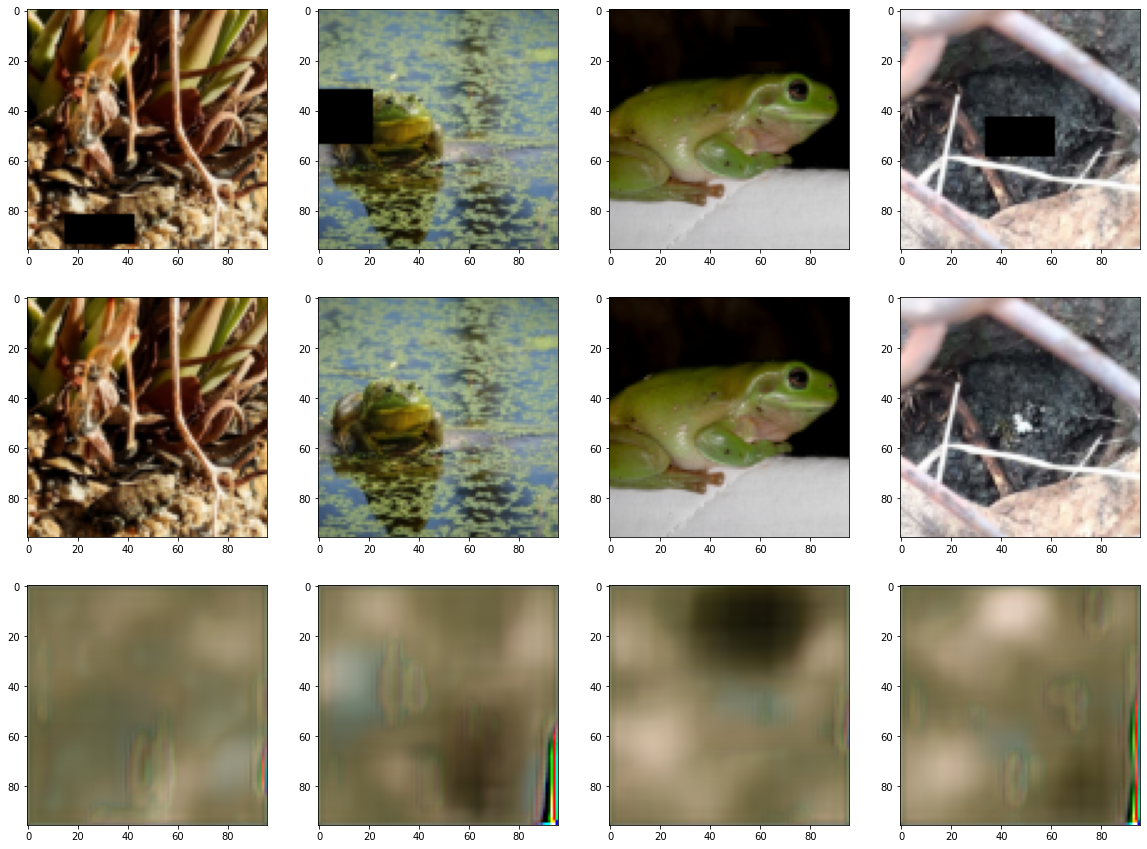

In [74]:
SAMPLE_SIZE = 4
loader = DataLoader(train_dataset, batch_size = SAMPLE_SIZE, shuffle = True)
batch = next(iter(loader))

# predict and plot
model.train()
output, kl = model(batch["image"].to(device).permute(0, 3, 1, 2))

high = output.max().detach().cpu()
low = output.min().detach().cpu()
output =(output.detach().cpu().permute(0, 2, 3, 1))
fig, ax = plt.subplots(3, SAMPLE_SIZE, figsize = (SAMPLE_SIZE * 5, 15, ))
for i in range(SAMPLE_SIZE):
    image = batch["image"][i]
    reconstructed = batch["reconstructed"][i]
    predicted = output[i]

    if image.shape[-1] > 3: 
        image = image[:, :, 0:3] # take rgb if more than 3 channels
        
    ax[0][i].imshow(image)
    ax[1][i].imshow(reconstructed)
    ax[2][i].imshow(predicted)
    
plt.show()

In [71]:
mask_segmented_loss(batch["reconstructed"], batch["reconstructed"],batch["mask"])

tensor(0.)

In [72]:
mask_segmented_loss(predicted, batch["reconstructed"],batch["mask"])

/home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([4, 96, 96, 3])) that is different to the input size (torch.Size([96, 96, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.4954)